# Data Science in Finance and Insurance - Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

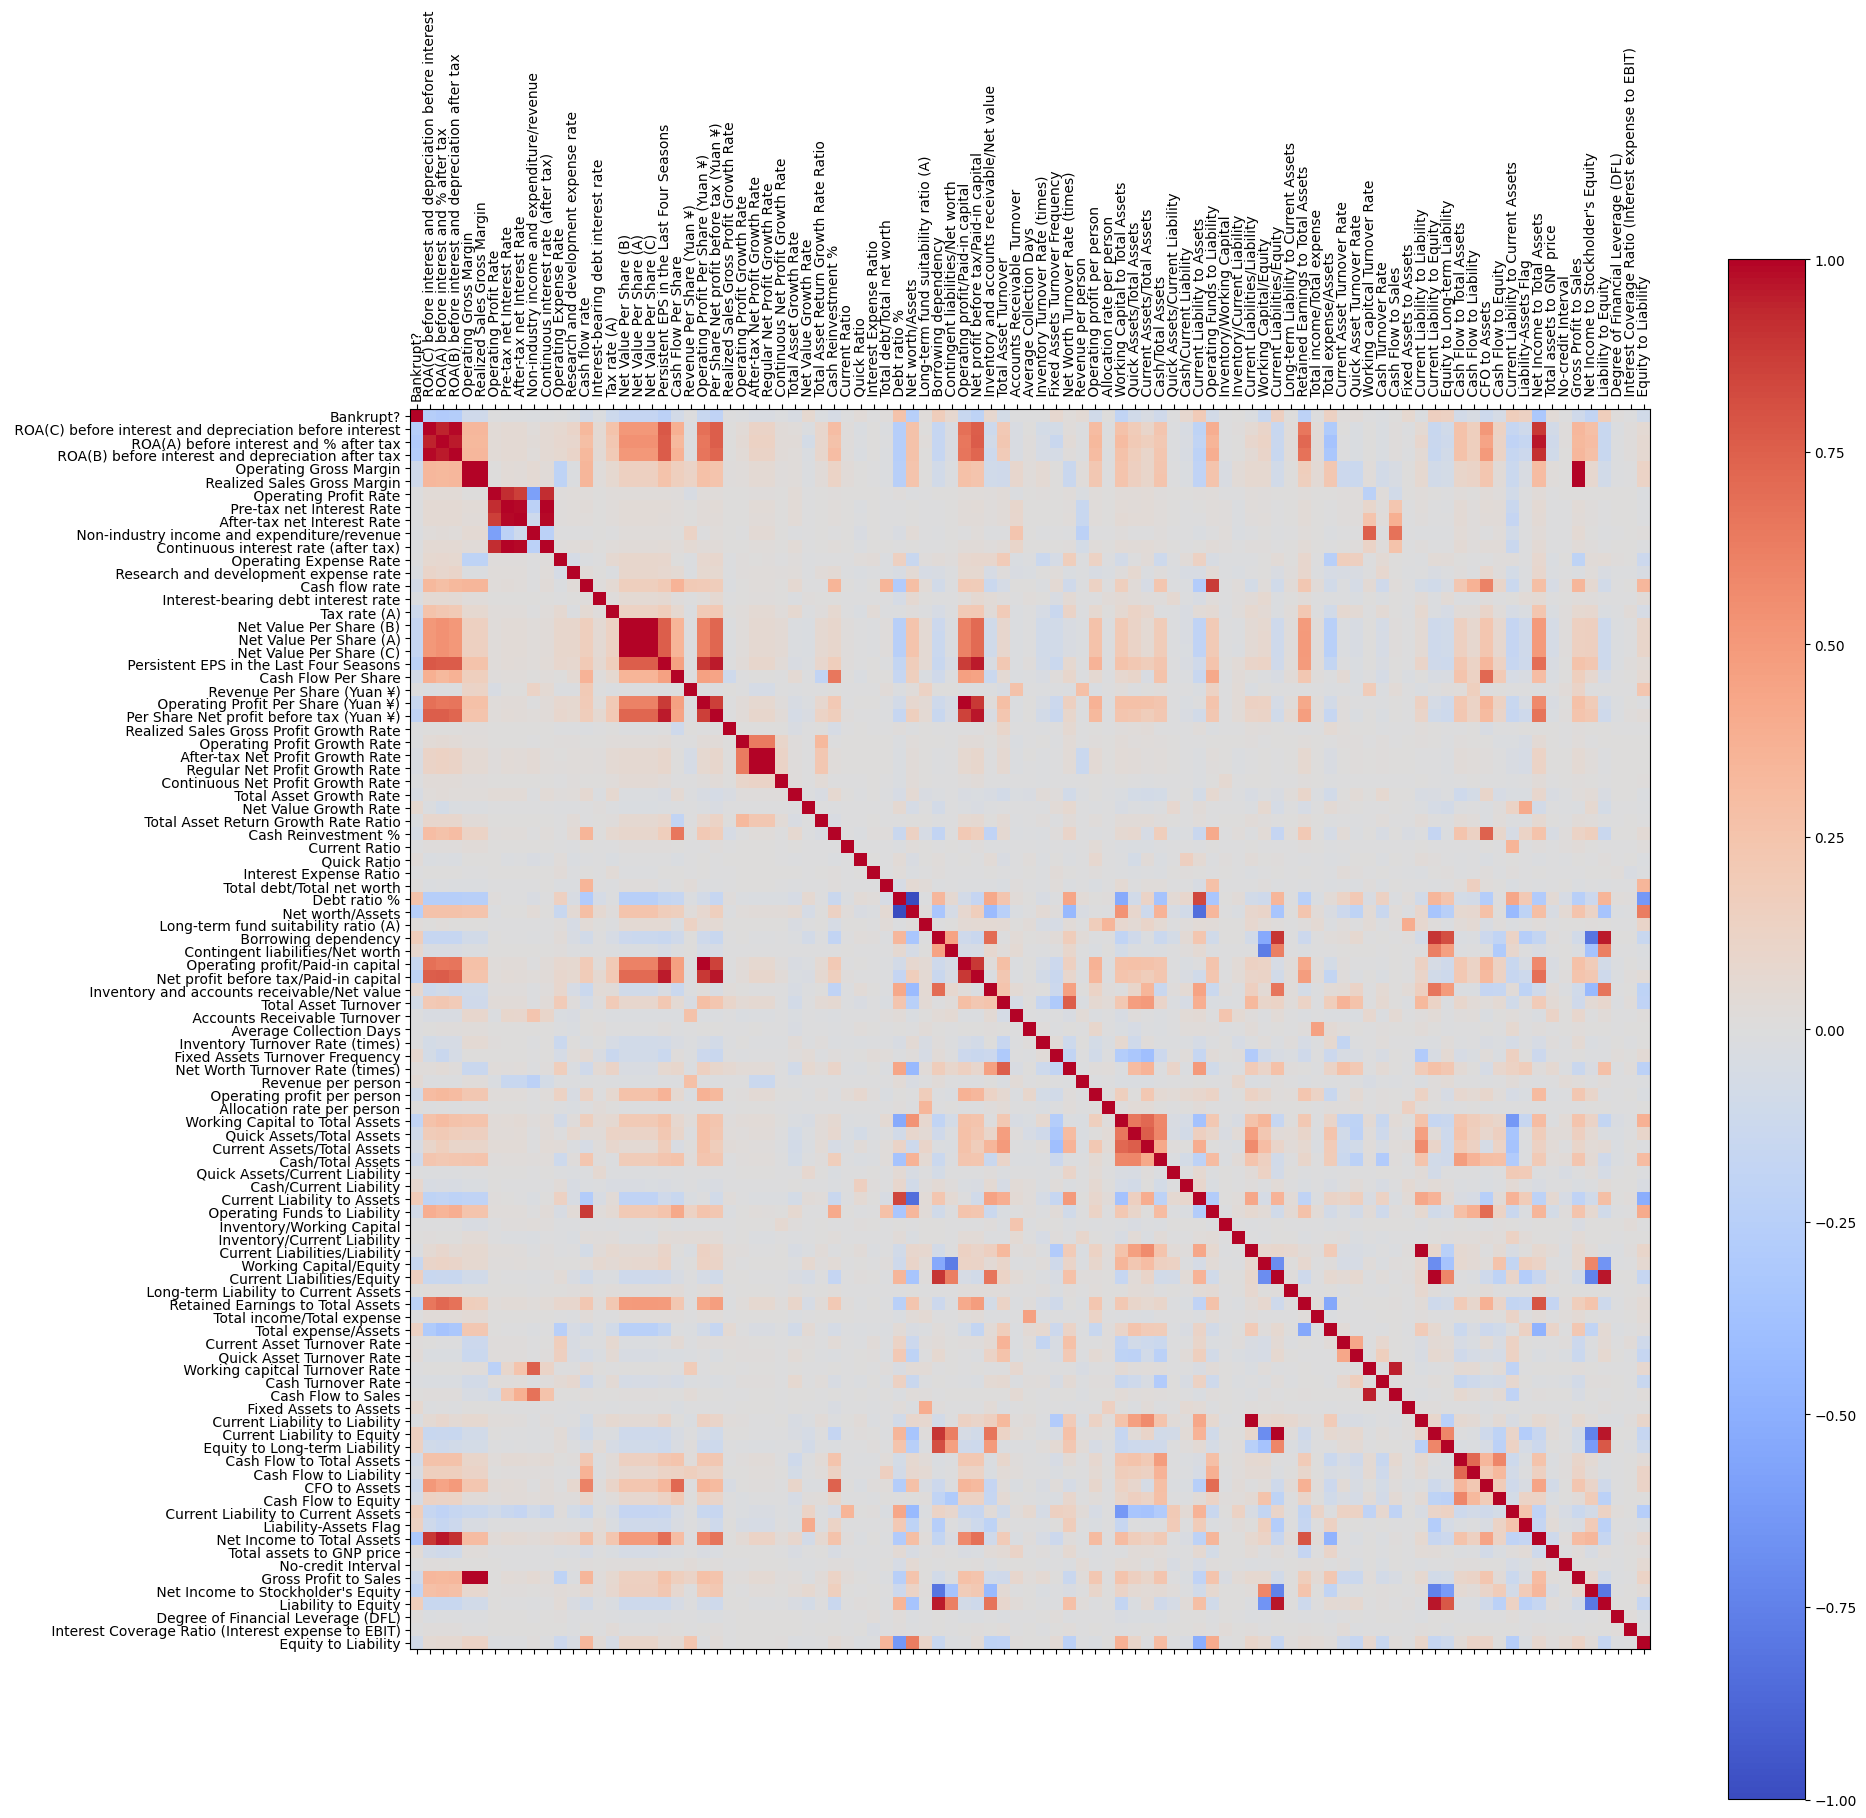

In [2]:
bdata = pd.read_csv("data.csv")
#Var[X_{Net Income Flag}] = 0, drop it
bdata = bdata.drop([' Net Income Flag'], axis = 1)

#Correlation Matrix
corrMat = bdata.corr()

#create color
fig,ax = plt.subplots(1,1, figsize = (20, 20))
cax = ax.matshow(corrMat, interpolation = 'nearest', cmap = "coolwarm")
fig.colorbar(cax)

list_cols = list(bdata.columns.values)
ax.set_xticks([i for i in range(len(list_cols))], labels = list_cols)
ax.set_yticks([i for i in range(len(list_cols))], labels = list_cols)
ax.tick_params(axis = 'x', labelrotation = 90)

plt.show()

In [3]:
# Find variables most correlated with Bankruptcy
lb_abs_corr = .1

bankCorr = corrMat['Bankrupt?'].sort_values(ascending = True)

negbankCorr = bankCorr[np.where(bankCorr <= -1 * lb_abs_corr, True, False)]

posbankCorr = bankCorr[np.where(bankCorr >= lb_abs_corr, True, False)][:-1]

print("Number of Relevant Variables:", negbankCorr.shape[0] + posbankCorr.shape[0])

Number of Relevant Variables: 32


In [4]:
important_variables = np.hstack((negbankCorr.index.values, posbankCorr.index.values))
important_variables

array([' Net Income to Total Assets',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' ROA(C) before interest and depreciation before interest',
       ' Net worth/Assets', ' Persistent EPS in the Last Four Seasons',
       ' Retained Earnings to Total Assets',
       ' Net profit before tax/Paid-in capital',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Working Capital to Total Assets',
       " Net Income to Stockholder's Equity", ' Net Value Per Share (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (C)',
       ' Working Capital/Equity', ' Operating Profit Per Share (Yuan ¥)',
       ' Operating profit/Paid-in capital', ' CFO to Assets',
       ' Tax rate (A)', ' Cash/Total Assets', ' Gross Profit to Sales',
       ' Operating Gross Margin', ' Equity to Long-term Liability',
       ' Total expense/Assets', ' Liability-Assets Flag',
       ' Current Liability to Equity', ' Current Lia

In [5]:
#Seperate X and Y
X = bdata.drop('Bankrupt?', axis = 1)
y = bdata['Bankrupt?']

## Principal Component Analysis

### PCA - Without Feature Selection

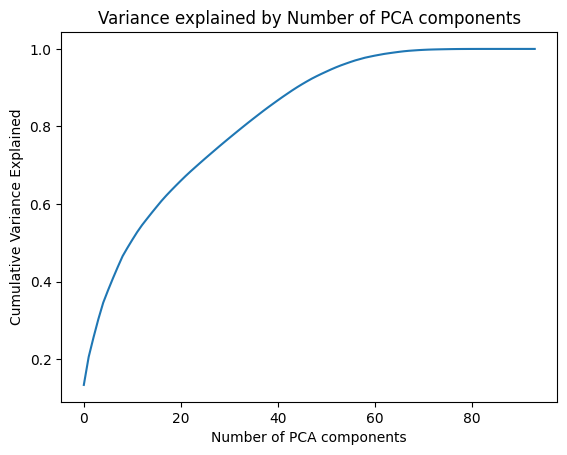

In [6]:
#Center and scale Data
X_std = StandardScaler().fit_transform(X)

#Implement PCA
pca = PCA().fit(X_std)
pca_data = pca.transform(X_std)

#graph explained variance
explained_var = np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_)
x = np.array([component for component in range(len(explained_var))])
plt.plot(x, explained_var)
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Variance explained by Number of PCA components")
plt.show()

In [7]:
#Explained variance ratio determined
var_ratio = .95
num_components = explained_var[np.where(explained_var < var_ratio, True, False)].shape[0]
#New Data generated
new_data = pca_data[:,0:num_components]
#Number of features explaining 95% variance
new_data.shape

(6819, 52)

### PCA - With Feature Selection

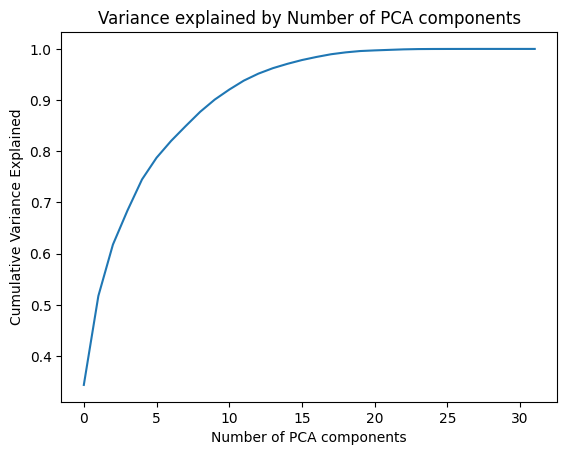

In [8]:
#Center and scale data
X_sub = X[important_variables]
X_sub_std = StandardScaler().fit_transform(X_sub)

#Implement PCA
pca_sub = PCA().fit(X_sub_std)
pca_data_sub = pca_sub.transform(X_sub_std)

#graph explained variance
explained_var_sub = np.cumsum(pca_sub.explained_variance_)/np.sum(pca_sub.explained_variance_)
x_sub = np.array([component for component in range(len(explained_var_sub))])
plt.plot(x_sub, explained_var_sub)
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Variance explained by Number of PCA components")
plt.show()

In [9]:
zeros = len(bdata['Bankrupt?'][np.where(bdata['Bankrupt?'].values == 0 , True, False)])
print("Number of Non-Bankrupt:", zeros)
print("Number of Bankrupt:", len(bdata['Bankrupt?']) - zeros)

Number of Non-Bankrupt: 6599
Number of Bankrupt: 220


In [10]:
prop_var = 0.95
pca_comp_needed = np.sum(np.where(explained_var_sub <= prop_var, 1, 0))
newX = pca_data_sub[:,0:pca_comp_needed]

# Algorithm Implementation

## Train,Test Split And Imbalanced Sampling

In [11]:
rseed = 42
#Split into train, test
newX_train, newX_test, y_train,y_test = train_test_split(newX, y, test_size = 0.2, random_state = rseed)
#Balance data
smote = SMOTE(random_state=rseed, sampling_strategy=1)
newX_train_smote, y_train_smote = smote.fit_resample(newX_train, y_train)

## Methods

### K-Nearest Neighbors

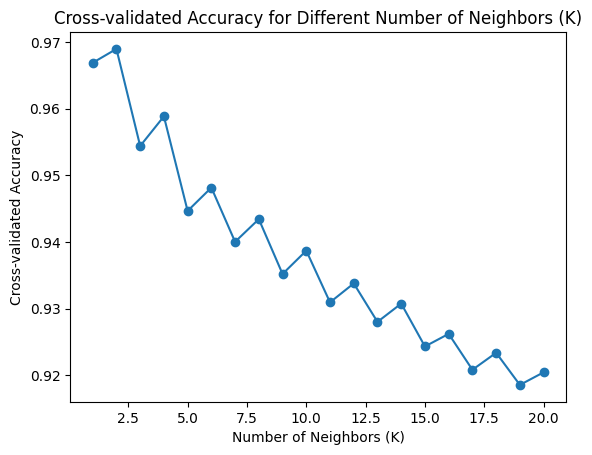

Optimal Number of Neighbors (K): 2
Cross-validated Accuracy with Optimal K: 0.97
Accuracy on the test set with optimal K: 0.94


In [12]:
accuracy_dict = {}

# Define the hyperparameter grid for k
param_grid = {'n_neighbors': range(1, 21)}  # You can adjust the range as needed

# Loop over the number of neighbors (K)
for k in param_grid['n_neighbors']:
    # Implement KNN with cross-validation
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Use GridSearchCV for cross-validated hyperparameter tuning
    grid_search = GridSearchCV(knn_model, param_grid={'n_neighbors': [k]}, cv=5)
    grid_search.fit(newX_train_smote, y_train_smote)
    
    # Store the best k and its corresponding accuracy
    best_accuracy = grid_search.best_score_
    accuracy_dict[k] = best_accuracy

# Find the optimal K with the highest accuracy
optimal_k = max(accuracy_dict, key=accuracy_dict.get)

# Visualize the results
plt.plot(param_grid['n_neighbors'], list(accuracy_dict.values()), marker='o')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Cross-validated Accuracy")
plt.title("Cross-validated Accuracy for Different Number of Neighbors (K)")
plt.show()

print(f"Optimal Number of Neighbors (K): {optimal_k}")
print(f"Cross-validated Accuracy with Optimal K: {accuracy_dict[optimal_k]:.2f}")

# Train the final model with the optimal K
knn_model_final = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model_final.fit(newX_train_smote, y_train_smote)

# Evaluate the final model on the test set
y_pred_knn = knn_model_final.predict(newX_test)
accuracy_final = accuracy_score(y_test, y_pred_knn)

print(f"Accuracy on the test set with optimal K: {accuracy_final:.2f}")

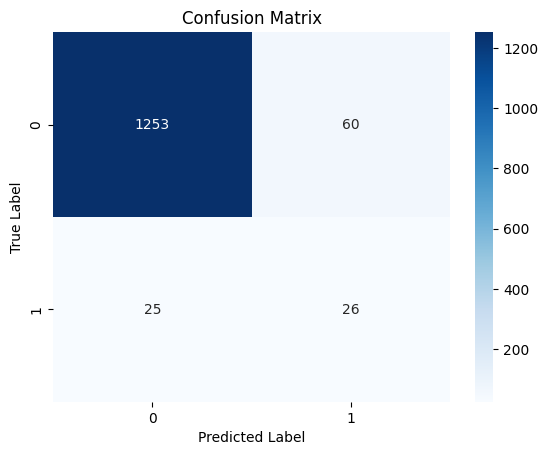

In [13]:
knn_conf_matrix = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Linear (and Quadratic) Discriminant Analysis

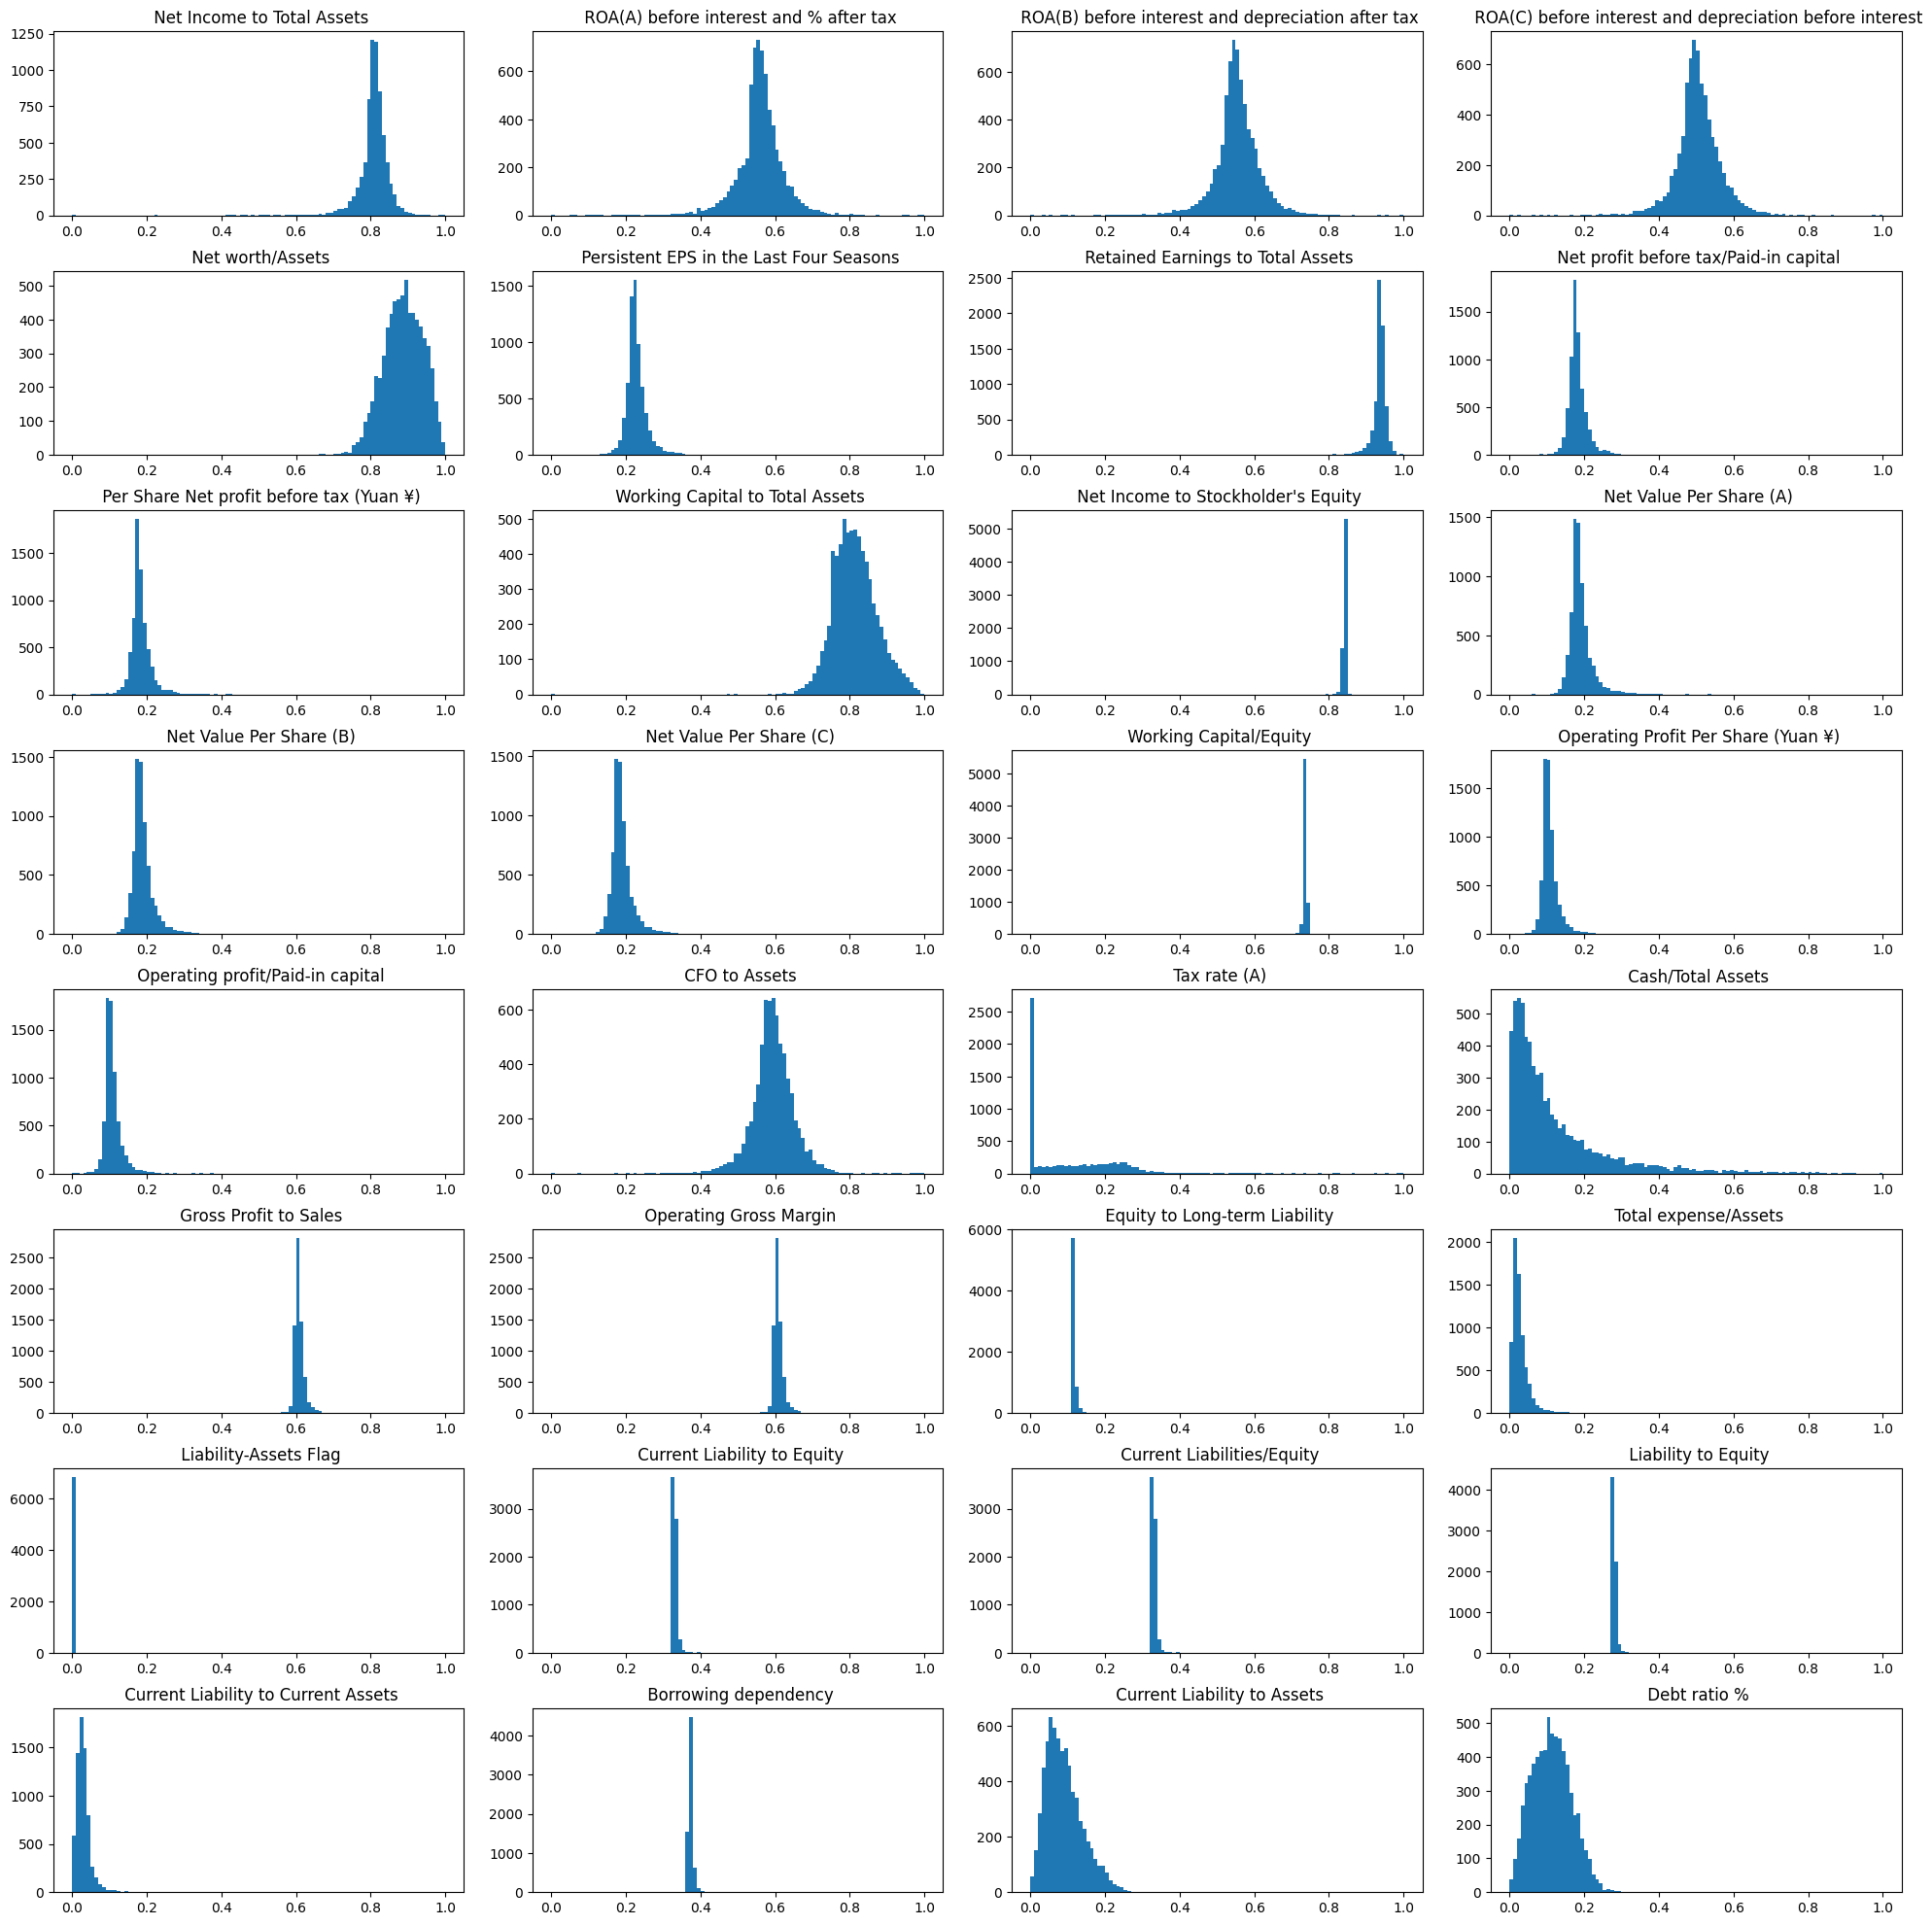

In [14]:
#Checking Normality of Features
axes = tuple(["ax{}".format(i) for i in range(1, 8 * 4 + 1)])
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (20,20))
fig.tight_layout(pad = 2)
count = 0
for i in range(8):
    for j in range(4):
        if count < len(important_variables):
            axes[i][j].hist(X[important_variables[count]], bins = 100)
            axes[i][j].set_title("{}".format(important_variables[count]))
            count += 1
        else:
            break


#### Linear Discriminant Analysis

In [15]:
ld = LinearDiscriminantAnalysis()
ld.fit(newX_train_smote, y_train_smote)
ld_predictions = ld.predict(newX_test)
print(classification_report(y_test, ld_predictions))
ld_conf_matrix = confusion_matrix(y_test, ld_predictions)

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1313
           1       0.18      0.90      0.30        51

    accuracy                           0.84      1364
   macro avg       0.59      0.87      0.60      1364
weighted avg       0.96      0.84      0.89      1364



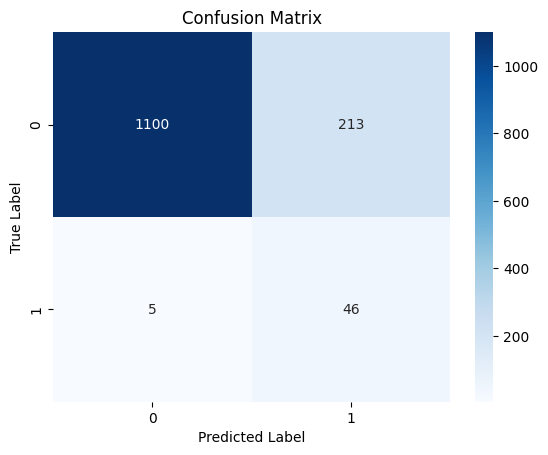

In [16]:
sns.heatmap(ld_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### Quadratic Discriminant Analysis

In [17]:
qd = QuadraticDiscriminantAnalysis()
qd.fit(newX_train_smote, y_train_smote)
qd_predictions = qd.predict(newX_test)
print(classification_report(y_test, qd_predictions))
qd_conf_matrix = confusion_matrix(y_test, qd_predictions)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1313
           1       0.42      0.37      0.40        51

    accuracy                           0.96      1364
   macro avg       0.70      0.68      0.69      1364
weighted avg       0.96      0.96      0.96      1364



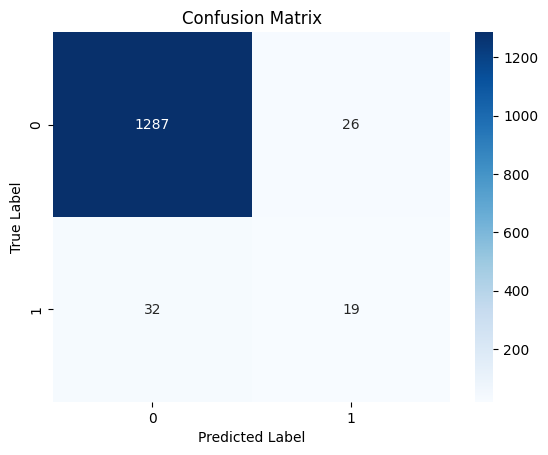

In [18]:
sns.heatmap(qd_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Logistic Regression

In [18]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Different values for regularization strength
    'penalty': ['l1', 'l2'],       # Different norms for penalization
    'solver': ['liblinear', 'saga']  # Solvers that support L1 penalty
}

# Create grid search object
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit on data
grid_search.fit(newX_train_smote, y_train_smote)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Best Score: 0.880155129263203


In [19]:
model = LogisticRegression(C=1, penalty='l1', solver='saga', max_iter=1000)
model.fit(newX_train_smote, y_train_smote)



predictions = model.predict(newX_test)
print(classification_report(y_test, predictions))
logit_conf_matrix = confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1313
           1       0.17      0.82      0.29        51

    accuracy                           0.85      1364
   macro avg       0.58      0.84      0.60      1364
weighted avg       0.96      0.85      0.89      1364



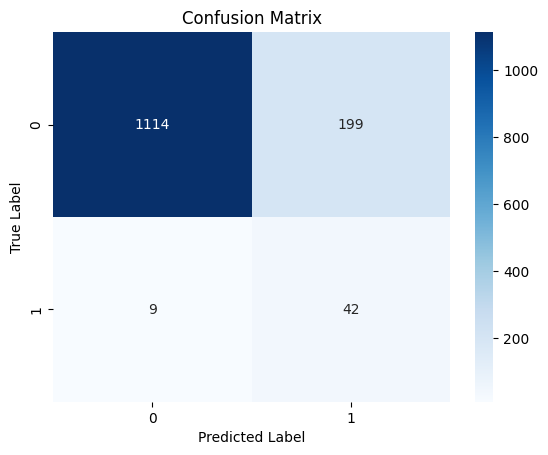

In [20]:
sns.heatmap(logit_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Naive Bayes

In [21]:
# Create and train the Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(newX_train_smote, y_train_smote)

# Evaluate the classifier on the test set
accuracy = gnb.score(newX_test, y_test)
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.9259530791788856


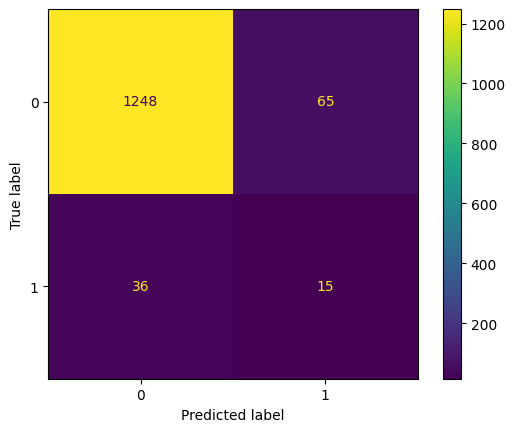

In [22]:
# Evaluate the GNB model with confusion matrix

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = gnb.predict(newX_test)
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
graph = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
graph.plot()
plt.show()

### Decision Tree

In [23]:
dt_model = DecisionTreeClassifier(random_state=42)

In [24]:
best_dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=4,
                       min_samples_split=10, random_state=42)

In [25]:
best_dt.fit(newX_train_smote, y_train_smote)
predictions = best_dt.predict(newX_test)

In [26]:
dt_conf_matrix = confusion_matrix(y_test, predictions)
print(dt_conf_matrix)

[[1194  119]
 [  22   29]]


In [27]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))

Accuracy: 0.8966275659824047
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      1313
           1       0.20      0.57      0.29        51

    accuracy                           0.90      1364
   macro avg       0.59      0.74      0.62      1364
weighted avg       0.95      0.90      0.92      1364



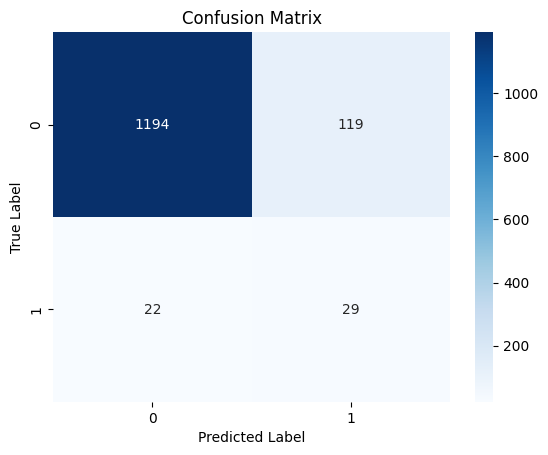

In [28]:
sns.heatmap(dt_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Random Forest

In [29]:
# Default Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(newX_train_smote, y_train_smote)
# Making predictions on the test set
rf_predictions = rf_model.predict(newX_test)

In [30]:
rf_conf_matrix = confusion_matrix(y_test, rf_predictions)
print(rf_conf_matrix)

[[1266   47]
 [  26   25]]


In [31]:
# Evaluating model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1313
           1       0.35      0.49      0.41        51

    accuracy                           0.95      1364
   macro avg       0.66      0.73      0.69      1364
weighted avg       0.96      0.95      0.95      1364



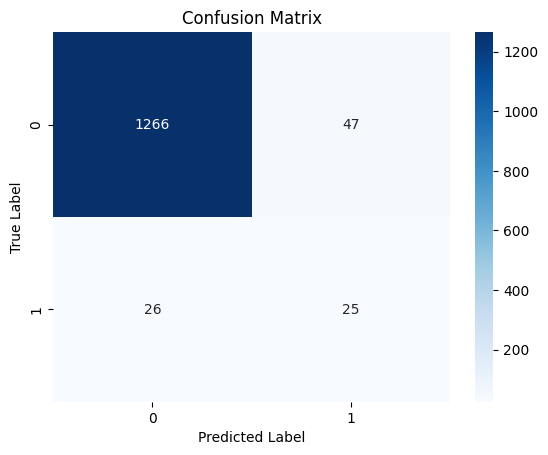

In [32]:
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Grid search for best hyperparameters
rf = RandomForestClassifier()

# Define grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'criterion': ['gini', 'entropy']
}

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(newX_train_smote, y_train_smote)


In [71]:
# Best parameters and model
print("Best parameters: ", grid_search.best_params_)
print("Best model: ", grid_search.best_estimator_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best model:  RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=400)


In [66]:
# Random Forest model
rf_best = RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=400, random_state=42)
rf_best.fit(newX_train_smote, y_train_smote)
# Making predictions on the test set
rf_predictions_best = rf_best.predict(newX_test)

RandomForestClassifier(criterion='entropy', max_depth=30, max_features='log2',
                       n_estimators=400, random_state=42)

In [68]:
rf_best_conf_matrix = confusion_matrix(y_test, rf_predictions_best)
print(rf_best_conf_matrix)

[[1263   50]
 [  21   30]]


In [69]:
# Evaluating model
rf_best_accuracy = accuracy_score(y_test, rf_predictions_best)
print(classification_report(y_test, rf_predictions_best))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1313
           1       0.38      0.59      0.46        51

    accuracy                           0.95      1364
   macro avg       0.68      0.78      0.72      1364
weighted avg       0.96      0.95      0.95      1364



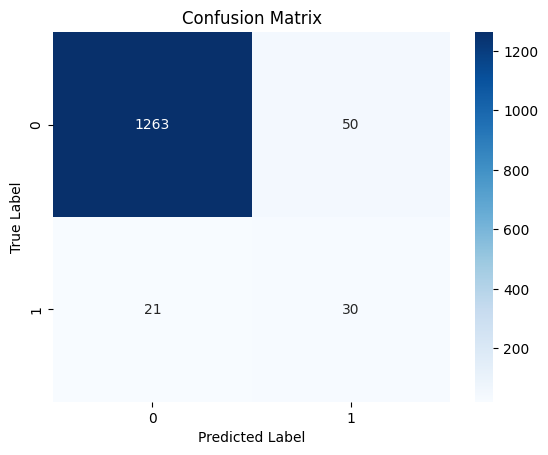

In [70]:
sns.heatmap(rf_best_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()